<a href="https://colab.research.google.com/github/fubotz/ICL_2024W/blob/main/FinalProject_Fabian_SCHAMBECK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project: Finetuning a Multilingual Model
Description here...

Model:

Dataset:

In [131]:
!pip install bertviz
!pip install datasets
!pip install evaluate
!pip install transformers
!pip install torch

In [132]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [133]:
from transformers import AutoTokenizer, AutoModel

# Load the multilingual DistilBERT model and tokenizer
model_name = "distilbert-base-multilingual-cased"
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

print(tokenizer)

DistilBertTokenizerFast(name_or_path='distilbert-base-multilingual-cased', vocab_size=119547, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)


In [134]:
# Define word pairs for cognate detection (n=21)
word_pairs = [
    ("academic", "académique"),
    ("administrator", "administrateur"),
    ("algorithm", "algorithme"),
    ("chemical", "chimique"),
    ("delicious", "délicieux"),
    ("emotion", "émotion"),
    ("exercise", "exercice"),
    ("gender", "genre"),
    ("gorilla", "gorille"),
    ("loyalty", "loyauté"),
    ("notation", "notamment"),
    ("objective", "objectif"),
    ("oratory", "oratoire"),
    ("particle", "particule"),
    ("quarter", "quartier"),
    ("september", "septembre"),
    ("skeleton", "squelette"),
    ("traditionally", "traditionnellement"),
    ("voice", "voix"),
    ("west", "ouest"),
    ("wine", "vin"),
]

In [135]:
def tokenize_word_pairs(word_pairs):
    """
    Tokenizes a list of word pairs for cognate detection.

    Parameters:
        word_pairs (list of tuples): A list of word pairs, where each tuple is (word1, word2).

    Returns:
        list of dict: A list of tokenized inputs for each word pair.
    """
    tokenized_pairs = []
    for word1, word2 in word_pairs:
        tokens = tokenizer(word1, word2, return_tensors="pt", padding=True, truncation=True)
        tokenized_pairs.append(tokens)
    return tokenized_pairs


# Tokenize the word pairs
tokenized_word_pairs = tokenize_word_pairs(word_pairs)

# Display tokenized outputs for the first word pair
print("First Word Pair Tokens:", tokenized_word_pairs[0])

First Word Pair Tokens: {'input_ids': tensor([[   101,  23765,    102,  13621,  11488, 101685,    102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}


['[CLS]', 'academic', '[SEP]', 'ac', '##ad', '##émique', '[SEP]']

In [136]:
def extract_embeddings(tokenized_word_pairs):
    """
    Extracts embeddings for tokenized word pairs.

    Parameters:
        tokenized_word_pairs (list of dict): Tokenized inputs for each word pair.

    Returns:
        list of tuple: A list of tuples containing embeddings for each word pair.
    """
    embeddings = []
    for tokens in tokenized_word_pairs:
        # Pass tokenized inputs through the model
        with torch.no_grad():
            outputs = model(**tokens)

        # Extract embeddings (last hidden state)
        hidden_states = outputs.last_hidden_state       # Shape: (batch_size, seq_len, hidden_dim)

        # Tokens are structured as: [CLS] word1 [SEP] word2 [SEP]
        # Find the [SEP] token to split the sequence
        sep_index = (tokens["input_ids"] == tokenizer.sep_token_id).nonzero(as_tuple=True)[1][0]

        # Pool embeddings for each word
        word1_embedding = hidden_states[0, 1:sep_index].mean(dim=0)     # Average token embeddings for word1
        word2_embedding = hidden_states[0, sep_index + 1:-1].mean(dim=0)        # Average token embeddings for word2

        embeddings.append((word1_embedding, word2_embedding))

    return embeddings

# Extract embeddings for the tokenized word pairs
embeddings_pt = extract_embeddings(tokenized_word_pairs)

Word 1 Embedding:

tensor([ 0.1234, -0.5678, ...,  0.3456])

Word 1 Embedding Dimensions: 1

Word 1 Embedding Shape: torch.Size([768])

In [137]:
import torch
from torch.nn.functional import cosine_similarity

def compute_similarity(embeddings_pt):
    """
    Computes cosine similarity between word embeddings for each word pair.

    Parameters:
        embeddings (list of tuple): List of (word1_embedding, word2_embedding).

    Returns:
        list of float: Cosine similarity scores for each word pair.
    """
    similarity_scores = []
    for word1_emb, word2_emb in embeddings:
        # Compute cosine similarity
        sim_score = cosine_similarity(
            word1_emb.unsqueeze(0), word2_emb.unsqueeze(0)
        ).item()
        similarity_scores.append(sim_score)
    return similarity_scores

# Compute cosine similarity for all word pairs
similarity_scores = compute_similarity(embeddings_pt)

# Display the scores
for i, (word1, word2) in enumerate(word_pairs):
    print(f"({word1}, {word2}): {similarity_scores[i]:.4f}")

(academic, académique): 0.6793
(administrator, administrateur): 0.7305
(algorithm, algorithme): 0.8454
(chemical, chimique): 0.7592
(delicious, délicieux): 0.7264
(emotion, émotion): 0.7299
(exercise, exercice): 0.8470
(gender, genre): 0.8717
(gorilla, gorille): 0.9240
(loyalty, loyauté): 0.8282
(notation, notamment): 0.7619
(objective, objectif): 0.8954
(oratory, oratoire): 0.9828
(particle, particule): 0.7477
(quarter, quartier): 0.8529
(september, septembre): 0.8642
(skeleton, squelette): 0.8359
(traditionally, traditionnellement): 0.6906
(voice, voix): 0.8239
(west, ouest): 0.8532
(wine, vin): 0.8252


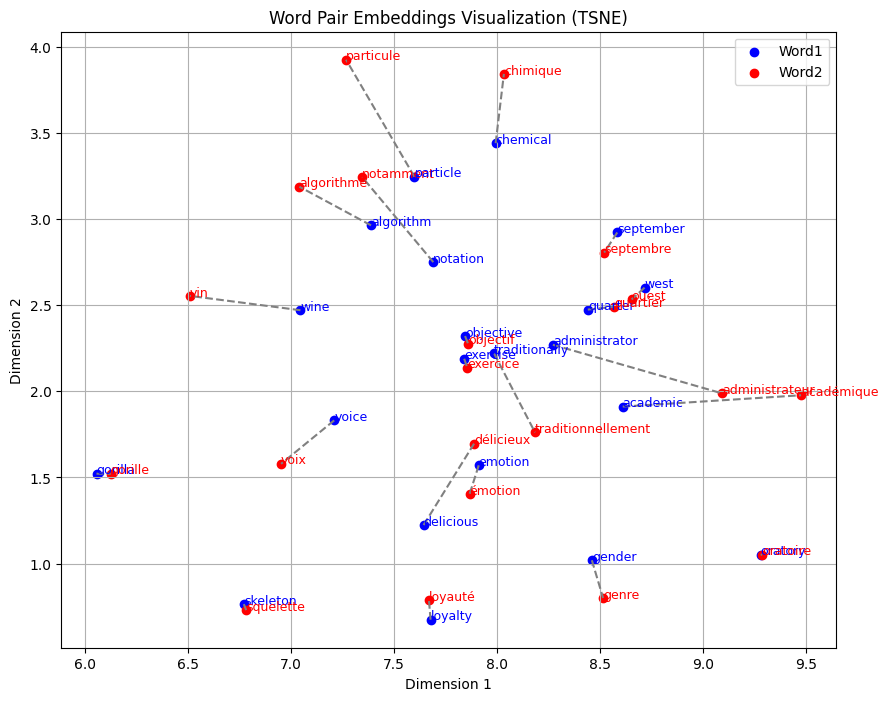

In [138]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def visualize_embeddings(embeddings, word_pairs, method="tsne", perplexity=30, n_components=2):
    """
    Visualizes word pair embeddings in a reduced embedding space.

    Parameters:
        embeddings (list of tuple): List of (word1_embedding, word2_embedding).
        word_pairs (list of tuple): Original list of word pairs.
        method (str): Dimensionality reduction method ('tsne' or 'pca').
        perplexity (int): Perplexity for t-SNE (only applicable for t-SNE).
        n_components (int): Number of dimensions for the reduced space.
    """
    # Combine word1 and word2 embeddings
    all_embeddings = torch.cat([torch.stack([e[0] for e in embeddings]),  # Word1 embeddings
                                torch.stack([e[1] for e in embeddings])]) # Word2 embeddings

    # Convert to numpy array
    all_embeddings_np = all_embeddings.numpy()

    # Reduce dimensions
    if method.lower() == "tsne":
        reducer = TSNE(n_components=n_components, perplexity=perplexity, random_state=42)
    elif method.lower() == "pca":
        reducer = PCA(n_components=n_components, random_state=42)
    else:
        raise ValueError("Invalid method. Choose 'tsne' or 'pca'.")

    reduced_embeddings = reducer.fit_transform(all_embeddings_np)

    # Split reduced embeddings back to word1 and word2
    word1_reduced = reduced_embeddings[:len(embeddings)]
    word2_reduced = reduced_embeddings[len(embeddings):]

    # Plot embeddings
    plt.figure(figsize=(10, 8))
    for i, (word1, word2) in enumerate(word_pairs):
        # Plot word1
        plt.scatter(word1_reduced[i, 0], word1_reduced[i, 1], color='blue', label="Word1" if i == 0 else "")
        plt.text(word1_reduced[i, 0], word1_reduced[i, 1], word1, fontsize=9, color='blue')

        # Plot word2
        plt.scatter(word2_reduced[i, 0], word2_reduced[i, 1], color='red', label="Word2" if i == 0 else "")
        plt.text(word2_reduced[i, 0], word2_reduced[i, 1], word2, fontsize=9, color='red')

        # Draw a line between word1 and word2
        plt.plot([word1_reduced[i, 0], word2_reduced[i, 0]],
                 [word1_reduced[i, 1], word2_reduced[i, 1]], color='gray', linestyle='dashed')

    # Add legend and title
    plt.legend()
    plt.title(f"Word Pair Embeddings Visualization ({method.upper()})")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid(True)
    plt.show()

# Call the visualization function
visualize_embeddings(embeddings_pt, word_pairs, method="tsne", perplexity=30)

In [139]:
from datasets import load_dataset

# Load the "Helsinki-NLP/europarl" dataset with the en-fr subset
dataset = load_dataset("Helsinki-NLP/europarl", "en-fr")

random_sample = dataset["train"].shuffle(seed=42).select(range(1000))

In [143]:
print("First 3 examples from the random sample:")
for i in range(3):
    example = random_sample[i]  # Access directly from the subset
    print(f"English: {example['translation']['en']}")
    print(f"French: {example['translation']['fr']}")
    print("-" * 50)

First 3 examples from the random sample:
English: As Europeans, with our experience, our culture of peace and our economic opportunities, we too are called upon to make our contribution towards a better future for Iraq.
French: Les Européens que nous sommes, avec leur expérience, leur culture de la paix et leurs moyens économiques, sont appelés à apporter leur contribution en faveur d'un avenir meilleur en Irak.
--------------------------------------------------
English: It does indeed speak for itself that those who are around the negotiating table are most sensitive to their own issues; this is always the case.
French: Il est d'ailleurs évident que les personnes qui siègent autour de la table de négociations sont les plus sensibles à leurs propres problèmes. Il en est toujours ainsi.
--------------------------------------------------
English: We nevertheless believe that the compromise is sound overall because it constitutes a clear improvement upon the original proposal.
French: Cep